<a href="https://colab.research.google.com/github/O-Kpy/Dacon/blob/main/Dacon_FIFA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/dataset/Dacon/연습/FIFA/FIFA_train.csv')
test = pd.read_csv('/content/drive/MyDrive/dataset/Dacon/연습/FIFA/FIFA_test.csv')
submit = pd.read_csv('/content/drive/MyDrive/dataset/Dacon/연습/FIFA/submission.csv')
train.shape, test.shape

((8932, 12), (3828, 11))

In [ ]:
data = pd.concat([train.drop(columns=['id']), test.drop(columns=['id'])])

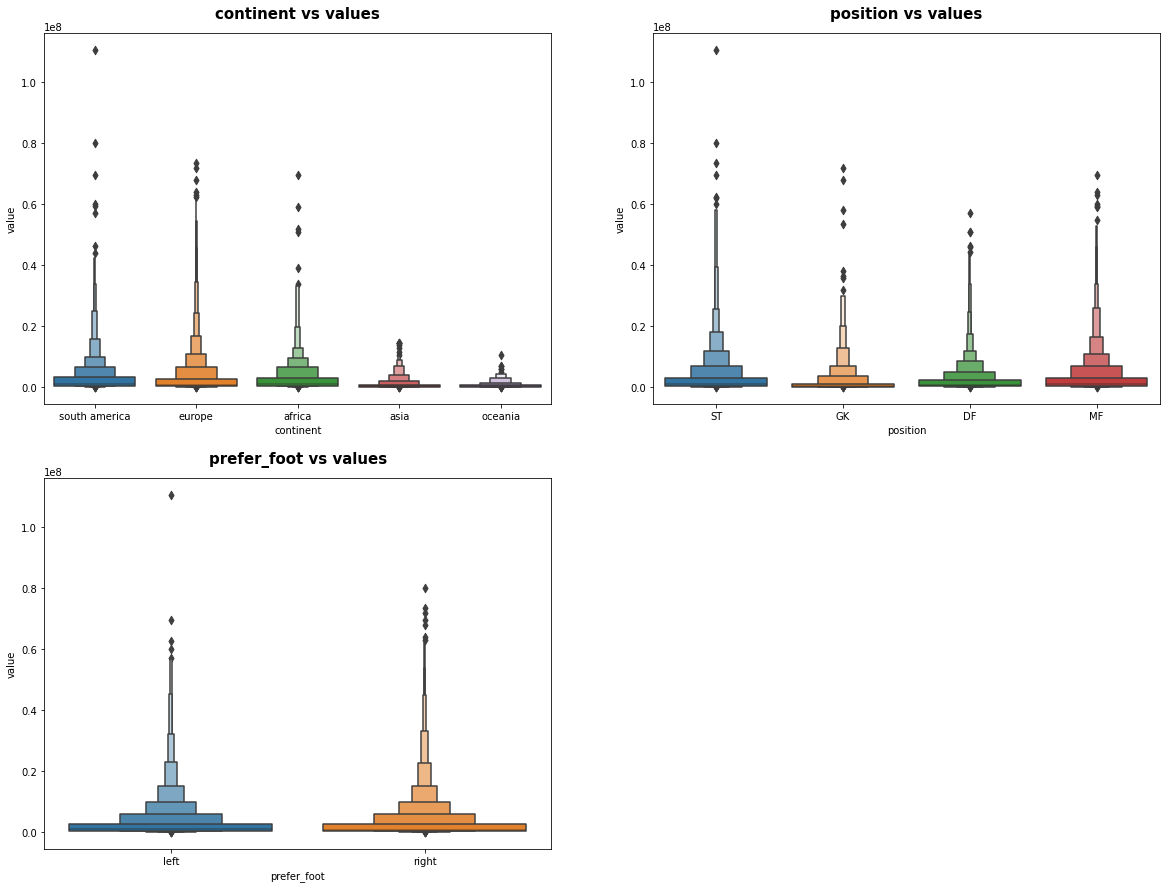

In [ ]:
plt.figure(figsize=(20,15))
for j, i in enumerate(data.select_dtypes('object').columns):
  if i in ['name']:
    continue
  plt.subplot(2,2, j)
  sns.boxenplot(x=i, y='value', data=data)
  plt.title(f'{i} vs values', fontsize=15, pad=15, fontweight='bold')


In [ ]:
data

,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value,age_bins,potential/overall
0,L. Messi,31,south america,2021,ST,left,5.0,94,94,4.0,110500000.0,old,1.000000
1,De Gea,27,europe,2020,GK,right,4.0,91,93,1.0,72000000.0,middle,1.021978
2,L. Suárez,31,south america,2021,ST,right,5.0,91,91,3.0,80000000.0,old,1.000000
3,Sergio Ramos,32,europe,2020,DF,right,4.0,91,91,3.0,51000000.0,old,1.000000
4,J. Oblak,25,europe,2021,GK,right,3.0,90,93,1.0,68000000.0,ealry,1.033333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3823,R. Takae,20,asia,2021,MF,right,1.0,48,63,2.0,NaN,youth,1.312500
3824,L. Wahlstedt,18,europe,2018,GK,right,1.0,48,65,1.0,NaN,youth,1.354167
3825,Y. Góez,18,south america,2021,MF,right,1.0,48,65,2.0,NaN,youth,1.354167
3826,A. Kaltner,18,europe,2020,ST,right,1.0,47,61,2.0,NaN,youth,1.297872


In [ ]:
data['contract_until'].value_counts()

2019           4067
2021           3293
2020           2938
2022           1099
2023            757
2018            580
2024             14
2025              7
Jan 1, 2019       3
2026              2
Name: contract_until, dtype: int64

In [ ]:
data.loc[data['contract_until'] == 'Jun 30, 2019', 'contract_until'] = '2019'
data.loc[data['contract_until'] == 'Dec 31, 2018', 'contract_until'] = '2018'
data.loc[data['contract_until'] == 'May 31, 2019', 'contract_until'] = '2019'
data.loc[data['contract_until'] == 'Jun 30, 2020', 'contract_until'] = '2020'
data.loc[data['contract_until'] == 'Jan 31, 2019', 'contract_until'] = '2019'
data.loc[data['contract_until'] == 'May 31, 2020', 'contract_until'] = '2020'
data.loc[data['contract_until'] == 'Jun 1, 2019', 'contract_until'] = '2019'
data.loc[data['contract_until'] == 'Jan 12, 2019', 'contract_until'] = '2019'
data.loc[data['contract_until'] == 'Dec 31, 2019', 'contract_until'] = '2019'
data.loc[data['contract_until'] == 'Jan 1, 2019', 'contract_until'] = '2019'

In [ ]:
data['contract_until'] = data['contract_until'].astype('int')

In [ ]:
bins = ['youth', 'young', 'ealry', 'middle', 'late', 'old']
data['age_bins'] = pd.qcut(data['age'], 6, labels=bins)

In [ ]:
data['potential/overall'] = data['stat_potential']/data['stat_overall']

In [ ]:
for i in data.select_dtypes(exclude='object').columns:
  if i in ['age_bins', 'value']:
    continue
  if data[i].skew() > 0.5:
    data[i] = boxcox1p(data[i], boxcox_normmax(data[i]+1))

In [ ]:
for i in data.select_dtypes(exclude='object').columns:
  if i in ['age_bins', 'value']:
    continue
  if data[i].skew() > 0.5:
    data[i] = np.log1p(data[i]+1)

In [ ]:
data = pd.get_dummies(data, columns=['age_bins'])

In [ ]:
x_train = data.loc[data.value.notnull()].drop(columns=['name', 'value'])
y_train = data.loc[data.value.notnull()]['value']
x_test = data.loc[data.value.isnull()].drop(columns=['name', 'value'])

In [ ]:
pip install catboost

     |████████████████████████████████| 69.2MB 43kB/s 


In [ ]:
pip install optuna

     |████████████████████████████████| 307kB 21.6MB/s 
     |████████████████████████████████| 81kB 6.8MB/s 
     |████████████████████████████████| 174kB 40.6MB/s 
     |████████████████████████████████| 143kB 43.2MB/s 
     |████████████████████████████████| 112kB 42.2MB/s 
     |████████████████████████████████| 51kB 5.9MB/s 
     |████████████████████████████████| 81kB 6.6MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-cp37-none-any.whl size=11136 sha256=2523d1ddf6869018045dd5fbf840a67fb037c3c68db2cc6e714e237d69279494
  Stored in directory: /root/.cache/pip/wheels/25/af/b8/3407109267803f4015e1ee2ff23be0c8c19ce4008665931ee1
Successfully built pyperclip


In [ ]:
import catboost
import lightgbm as lgbm
import optuna
from sklearn.model_selection import StratifiedKFold, KFold, cross_validate
from sklearn.metrics import mean_squared_error

In [ ]:
kf = KFold(n_splits=7, shuffle=True, random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cat_features=x_train.select_dtypes(include='object')

preds_cat = np.zeros((x_test.shape[0]))


for i, (train_index, valid_index) in enumerate(skf.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model_cat = catboost.CatBoostRegressor(learning_rate=0.22, loss_function='RMSE', cat_features=cat_features, n_estimators=3000, eval_metric='RMSE')
  model_cat.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)], early_stopping_rounds=70, verbose=100)

  preds_cat = model_cat.predict(x_test)

0:	learn: 4700298.9790626	test: 5476070.8735706	best: 5476070.8735706 (0)	total: 8.01ms	remaining: 24s
100:	learn: 289603.4901644	test: 1056448.0498100	best: 1056448.0498100 (100)	total: 702ms	remaining: 20.1s
200:	learn: 210153.9347708	test: 1027318.3820098	best: 1027318.3820098 (200)	total: 1.39s	remaining: 19.4s
300:	learn: 175289.7828471	test: 1021976.8924784	best: 1021295.2612652 (271)	total: 2.1s	remaining: 18.8s
400:	learn: 155734.8067730	test: 1019235.9286512	best: 1018809.3944529 (330)	total: 2.77s	remaining: 17.9s
Stopped by overfitting detector  (70 iterations wait)

bestTest = 1018809.394
bestIteration = 330

Shrink model to first 331 iterations.
0:	learn: 4824937.5035617	test: 4653713.1088205	best: 4653713.1088205 (0)	total: 7.76ms	remaining: 23.3s
100:	learn: 312507.8409793	test: 668275.0152709	best: 668275.0152709 (100)	total: 645ms	remaining: 18.5s
200:	learn: 212592.2069054	test: 616053.7751530	best: 616053.7751530 (200)	total: 1.31s	remaining: 18.3s
300:	learn: 176251

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/dataset/Dacon/연습/FIFA/submission.csv')
submit['value'] = preds_cat
submit = submit.set_index('id')
submit.to_csv('/content/drive/MyDrive/dataset/Dacon/연습/FIFA/submit4.csv')